# dense-crowd-counting_crowdnet

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
import scipy.io
from skimage.transform import downscale_local_mean
import os
import sys
import json
import math
import time
import random
from random import shuffle
import pickle
import h5py
import glob

#caffe
caffe_root = os.path.expanduser('~/caffe/CrowdCount/deeplab_v2') # change with your install location
sys.path.insert(0, os.path.join(caffe_root, 'python'))
sys.path.insert(0, os.path.join(caffe_root, 'python/caffe/proto'))
import caffe
import caffe_pb2

In [2]:
#constants

project_path='~/caffe/CrowdCount/deep-crowd-counting_crowdnet-master/'
model_name = 'dcc_crowdnet'
model_path = os.path.expanduser(os.path.join(project_path+'models', model_name))
data_path = os.path.expanduser(os.path.join(project_path+'data', model_name))
weights_path = os.path.expanduser(os.path.join(project_path+'models', model_name))

dataset_paths = ['dataset/UCF_CC_50']

slice_w = 256
slice_h = 256

patch_w = 225
patch_h = 225

net_density_h = 28
net_density_w = 28

HAS_GPU = True
GPU_ID = 0

In [3]:
#mean
VGG_ILSVRC_16_layers_mean = np.zeros((3, patch_h, patch_w), dtype='f4')
VGG_ILSVRC_16_layers_mean[0,:,:] = 103.939
VGG_ILSVRC_16_layers_mean[1,:,:] = 116.779
VGG_ILSVRC_16_layers_mean[2,:,:] = 123.68

# DCC Train

In [4]:
def load_gt_from_json(gt_file, gt_shape):
    gt = np.zeros(gt_shape, dtype='uint8') 
    with open(gt_file, 'r') as jf:
        for j, dot in enumerate(json.load(jf)):
            try:
                gt[int(math.floor(dot['y'])), int(math.floor(dot['x']))] = 1
            except IndexError:
                print gt_file, dot['y'], dot['x'], sys.exc_info()
    return gt

def load_images_and_gts(path):
    images = []
    gts = []
    densities = []
    for gt_file in glob.glob(os.path.join(path, '*.json')):
        print gt_file
        if os.path.isfile(gt_file.replace('.json','.png')):
            img = cv2.imread(gt_file.replace('.json','.png'))
        else:
            img = cv2.imread(gt_file.replace('.json','.jpg'))
        images.append(img)
        
        #load ground truth
        gt = load_gt_from_json(gt_file, img.shape[:-1])
        gts.append(gt)
        
        #densities
        desnity_file = gt_file.replace('.json','.h5')
        if os.path.isfile(desnity_file):
            #load density if exist
            with h5py.File(desnity_file, 'r') as hf:
                density = np.array(hf.get('density'))
        else:
            density = gaussian_filter_density([gt])[0]
            with h5py.File(desnity_file, 'w') as hf:
                hf['density'] = density
        densities.append(density)
    print path, len(images), 'loaded'
    return (images, gts, densities)

In [5]:
def density_resize(density, fx, fy):
    return cv2.resize(density, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)/(fx*fy)

def multiscale_pyramidal(images, gts, start=0.5, end=1.3, step=0.1):
    frange = np.arange(start, end, step)
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        for f in frange:
            out_images.append(cv2.resize(img, None, fx=f, fy=f, interpolation = cv2.INTER_CUBIC))
            out_gts.append(density_resize(gts[i], fx=f, fy=f))
    return (out_images, out_gts)

def adapt_images_and_densities(images, gts, slice_w=slice_w, slice_h=slice_h):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape
        n_slices_h = int(round(img_h/slice_h))
        n_slices_w = int(round(img_w/slice_w))
        new_img_h = float(n_slices_h * slice_h)
        new_img_w = float(n_slices_w * slice_w)
        fx = new_img_w/img_w
        fy = new_img_h/img_h
        out_images.append(cv2.resize(img, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC))
        assert out_images[-1].shape[0]%slice_h == 0 and out_images[-1].shape[1]%slice_w == 0
        if gts is not None:
            out_gts.append(density_resize(gts[i], fx, fy))
    return (out_images, out_gts)

#Generate slices
def generate_slices(images, gts, slice_w=slice_w, slice_h=slice_h, offset=None):
    if offset == None:
        offset = slice_w
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape        
        p_y_id = 0
        p_y1 = 0
        p_y2 = p_y1 + slice_h
        while p_y2 <= img_h:
            p_x_id = 0
            p_x1 = 0
            p_x2 = p_x1 + slice_w
            while p_x2 <= img_w:
                out_images.append(img[p_y1:p_y2,p_x1:p_x2])
                assert out_images[-1].shape[:-1] == (slice_h, slice_w)
                if gts is not None:
                    out_gts.append(gts[i][p_y1:p_y2,p_x1:p_x2])
                    assert out_gts[-1].shape == (slice_h, slice_w)
                #next
                p_x_id += 1
                p_x1 += offset
                p_x2 += offset
            p_y_id += 1
            p_y1 += offset
            p_y2 += offset
    return (out_images, out_gts)

#Data augmentation: CROP
def crop_slices(images, gts):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        #data augmentation
        #crop-5
        img_h, img_w, _ = img.shape
        gt = gts[i]
        #top-left
        p_y1, p_y2 = 0, patch_h
        p_x1, p_x2 = 0, patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #top-right
        p_y1, p_y2 = 0, patch_h
        p_x1, p_x2 = img_w-patch_w, img_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #bottom-left
        p_y1, p_y2 = img_h-patch_h, img_h
        p_x1, p_x2 = 0, patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #bottom-right
        p_y1, p_y2 = img_h-patch_h, img_h
        p_x1, p_x2 = img_w-patch_w, img_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #center
        p_y1, p_y2 = int((img_h-patch_h)/2), int((img_h-patch_h)/2)+patch_h
        p_x1, p_x2 = int((img_w-patch_w)/2), int((img_w-patch_w)/2)+patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
    return (out_images, out_gts)


#Data augmentation: FLIP
def flip_slices(images, gts):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape
        gt = gts[i]
        #original
        out_images.append(img)
        out_gts.append(gt)
        #flip: left-right
        out_images.append(np.fliplr(img))
        out_gts.append(np.fliplr(gt))
    return (out_images, out_gts)

#Shuffling
def shuffle_slices(images, gts):
    out_images = []
    out_gts = []
    index_shuf = range(len(images))
    shuffle(index_shuf)
    for i in index_shuf:
        out_images.append(images[i])
        out_gts.append(gts[i])
    return (out_images, out_gts)

def samples_distribution(images, gts):
    out_images = []
    out_gts = []
    gts_count = map(np.sum, gts)
    max_count = max(gts_count)
    #pos
    for i, img in enumerate(images):
        if gts_count[i] >= 1. and random.random() < gts_count[i]**2/max_count**2:
            out_images.append(img)
            out_gts.append(gts[i])
    #neg
    neg_count = sum(gt_count < 1. for gt_count in gts_count)
    obj_neg_count = len(out_gts) / 6 # ~= 15-16%
    neg_keep_prob = min(1., float(obj_neg_count) / float(neg_count))
    for i, img in enumerate(images):
        if gts_count[i] < 1. and random.random() < neg_keep_prob:
            out_images.append(img)
            out_gts.append(gts[i])
        
    return (out_images, out_gts)

In [6]:
from scipy import stats

def gaussian_filter_density(gts):
    densities = []
    for gt in gts:
        print gt.shape
        density = np.zeros(gt.shape, dtype=np.float32)
        gt_count = np.count_nonzero(gt)
        if gt_count == 0:
            return density

        pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
        leafsize = 2048
        # build kdtree
        #print 'build kdtree...'
        tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
        # query kdtree
        #print 'query kdtree...' 
        distances, locations = tree.query(pts, k=2, eps=10.)

        #print 'generate density...'
        for i, pt in enumerate(pts):
            pt2d = np.zeros(gt.shape, dtype=np.float32)
            pt2d[pt[1],pt[0]] = 1.
            if gt_count > 1:
                sigma = distances[i][1]
            else:
                sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
            density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        #print 'done.'
        densities.append(density)
    return densities

In [7]:
# Positive image and ground truth loading
X_fs = []
Y_fs = []

for path in dataset_paths:
    images, gts, densities = load_images_and_gts(path)
    X_fs += images
    Y_fs += densities

dataset/UCF_CC_50/15.json
dataset/UCF_CC_50/37.json
dataset/UCF_CC_50/48.json
dataset/UCF_CC_50/40.json
dataset/UCF_CC_50/20.json
dataset/UCF_CC_50/4.json
dataset/UCF_CC_50/9.json
dataset/UCF_CC_50/17.json
dataset/UCF_CC_50/22.json
dataset/UCF_CC_50/7.json
dataset/UCF_CC_50/42.json
dataset/UCF_CC_50/26.json
dataset/UCF_CC_50/25.json
dataset/UCF_CC_50/34.json
dataset/UCF_CC_50/2.json
dataset/UCF_CC_50/6.json
dataset/UCF_CC_50/16.json
dataset/UCF_CC_50/8.json
dataset/UCF_CC_50/12.json
dataset/UCF_CC_50/3.json
dataset/UCF_CC_50/18.json
dataset/UCF_CC_50/46.json
dataset/UCF_CC_50/5.json
dataset/UCF_CC_50/21.json
dataset/UCF_CC_50/24.json
dataset/UCF_CC_50/23.json
dataset/UCF_CC_50/31.json
dataset/UCF_CC_50/32.json
dataset/UCF_CC_50/45.json
dataset/UCF_CC_50/41.json
dataset/UCF_CC_50/13.json
dataset/UCF_CC_50/50.json
dataset/UCF_CC_50/49.json
dataset/UCF_CC_50/35.json
dataset/UCF_CC_50/14.json
dataset/UCF_CC_50/38.json
dataset/UCF_CC_50/33.json
dataset/UCF_CC_50/39.json
dataset/UCF_CC_50/11

In [8]:
# Split test an train set
from sklearn.model_selection import train_test_split

# Train 80%, Test 20%
X_fs_train, X_fs_test, Y_fs_train, Y_fs_test = train_test_split(X_fs, Y_fs, test_size=0.2)

In [9]:
# FS: FULL SIZE
X_train, Y_train = X_fs_train, Y_fs_train
X_test, Y_test = X_fs_test, Y_fs_test
#print len(X_train), len(Y_train)
#print len(X_test), len(Y_test)

# DATA AUGMENTATION
#print '\nMultiscale pyramidal'
#print 'TRAIN:'
#X_train, Y_train = multiscale_pyramidal(X_train, Y_train)
#print len(X_train), len(Y_train)
#print 'TEST:'
#X_test, Y_test = multiscale_pyramidal(X_test, Y_test)
#print len(X_test), len(Y_test)

# PATCH SIZE
print '\nGenerate slices'
print 'TRAIN:'
X_train, Y_train = generate_slices(X_train, Y_train, slice_w=patch_w, slice_h=patch_h, offset=8)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = generate_slices(X_test, Y_test, slice_w=patch_w, slice_h=patch_h)
print len(X_test), len(Y_test)

print '\nFlip'
print 'TRAIN:'
X_train, Y_train = flip_slices(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = flip_slices(X_test, Y_test)
print len(X_test), len(Y_test)

print '\nSamples gt distribution correction'
print 'TRAIN:'
X_train, Y_train = samples_distribution(X_train, Y_train)
print len(X_train), len(Y_train)

print '\nShuffle'
print 'TRAIN:'
X_train, Y_train = shuffle_slices(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, y_test = shuffle_slices(X_test, Y_test)
print len(X_test), len(Y_test)


Generate slices
TRAIN:
194496 194496
TEST:
90 90

Flip
TRAIN:
388992 388992
TEST:
180 180

Samples gt distribution correction
TRAIN:
28825 28825

Shuffle
TRAIN:
28825 28825
TEST:
180 180


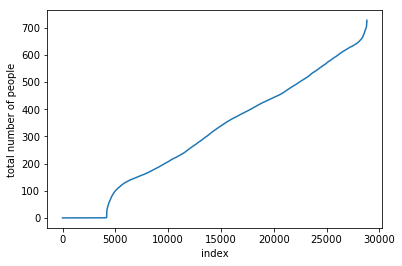

In [10]:
#Plot TRAIN samples distribution
#Y_train_sum = filter(lambda x: True, map(np.sum, Y_train))
Y_train_sum = map(np.sum, Y_train)
Y_train_sum.sort()
plt.plot(Y_train_sum)
plt.xlabel('index')
plt.ylabel('total number of people')
plt.show()

In [11]:
# Write out the data to HDF5 files

def process_dump_to_hdf5data(X, Y, path, phase, mean):
    if not os.path.exists(path):
        os.makedirs(path)
    
    batch_size = 7000 #due to hf5 files size limit
    
    X_process = np.zeros((batch_size, 3, patch_h, patch_w), dtype=np.float32) 
    Y_process = np.zeros((batch_size, net_density_h, net_density_w), dtype=np.float32)
    print 'batch_size=',batch_size,'len(X)=',len(X)
    with open(os.path.join(path, phase+'.txt'), 'w') as f:
        i1 = 0
        while i1 < len(X):
            if i1+batch_size < len(X):
                i2 = i1+batch_size
            else:
                i2 = len(X)
            print i1,'-', i2-1,'/',len(X)
            file_name = os.path.join(path, phase+'_'+str(i1)+'.h5')
            with h5py.File(file_name, 'w') as hf:
                #process batch
                for j, img in enumerate(X[i1:i2]):
                    X_process[j] = img.copy().transpose(2,0,1).astype(np.float32) - mean
                    Y_process[j] = density_resize(Y[i1+j], fx=float(net_density_w)/patch_w, fy=float(net_density_h)/patch_h)
                hf['data'] = X_process[:(i2-i1)]
                hf['label'] = Y_process[:(i2-i1)]
            f.write(file_name + '\n')
            i1 += batch_size
            

# Train
print 'TRAIN:'
process_dump_to_hdf5data(X_train, Y_train, data_path, 'train', VGG_ILSVRC_16_layers_mean)
# Test
print 'TEST:'
process_dump_to_hdf5data(X_test, Y_test, data_path, 'test', VGG_ILSVRC_16_layers_mean)

TRAIN:
batch_size= 7000 len(X)= 28825
0 - 6999 / 28825
7000 - 13999 / 28825
14000 - 20999 / 28825
21000 - 27999 / 28825
28000 - 28824 / 28825
TEST:
batch_size= 7000 len(X)= 180
0 - 179 / 180


### Visualize

In [15]:
def list_to_np_array(in_list):
    max_h = 0
    max_w = 0
    for i, item in enumerate(in_list):
        if item.shape[0] > max_h:
            max_h = item.shape[0]
        if item.shape[1] > max_w:
            max_w = item.shape[1]
    out_arr = np.zeros((len(in_list), max_h, max_w, 3))
    for i, item in enumerate(in_list):
        pad_h = max_h - item.shape[0]
        pad_w = max_w - item.shape[1]
        out_arr[i] = np.pad(item, ((0,pad_h),(0,pad_w),(0,0)), mode='constant', constant_values=0.)
    return out_arr

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=(30,30))
    plt.imshow(data)
    plt.axis('off')

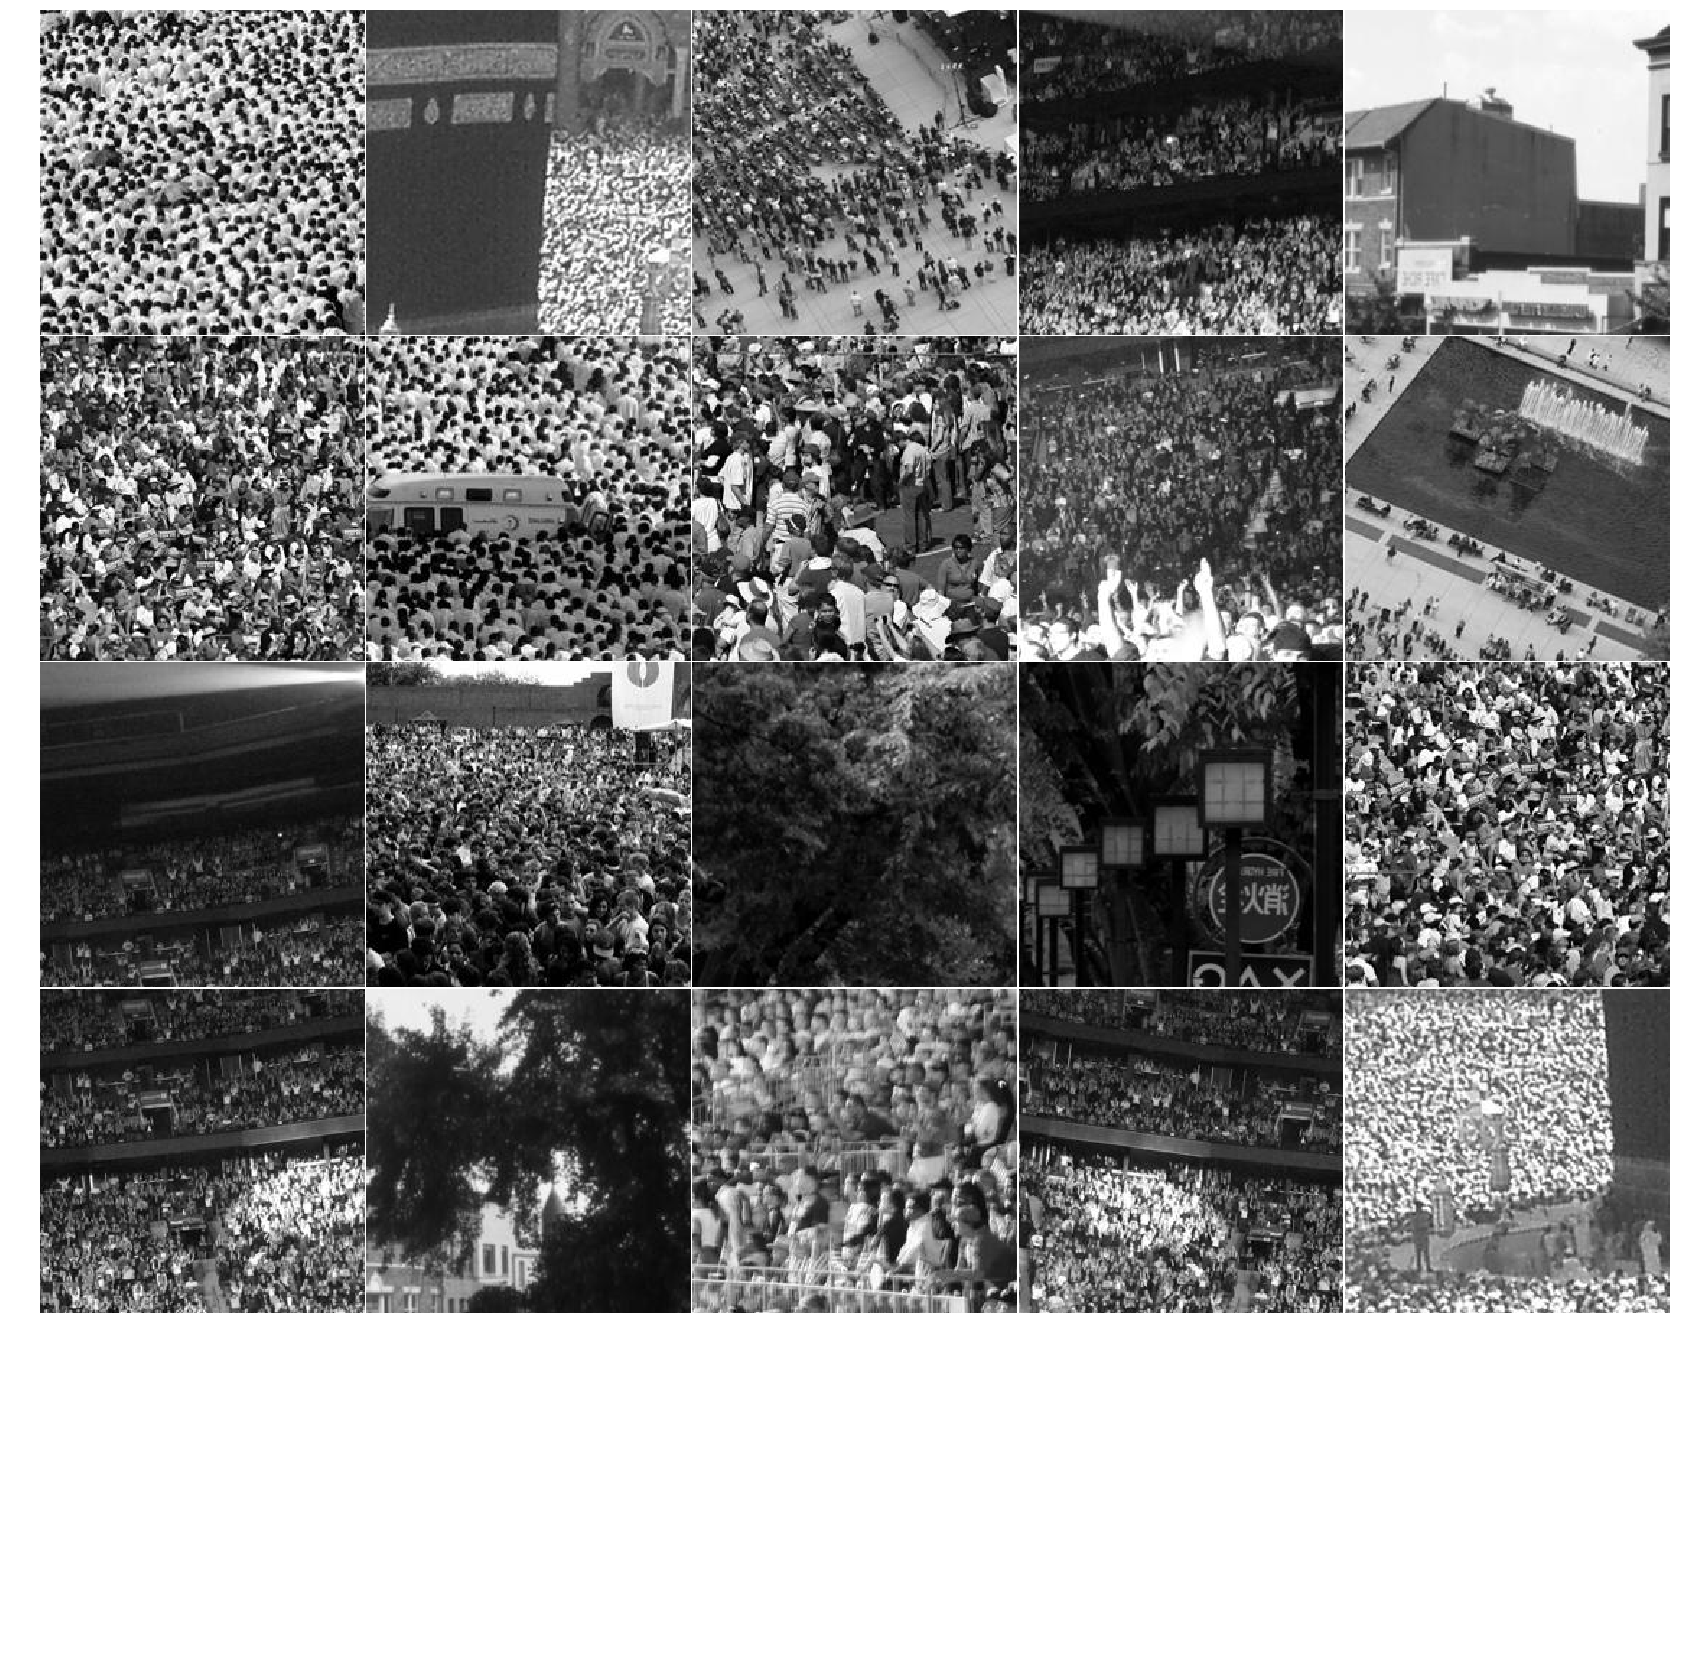

In [16]:
vis_square(list_to_np_array(X_train[:20]))

训练集图像总数: 28825
随机选取的下标为: 10188
真实人数: 357


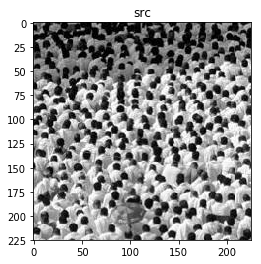

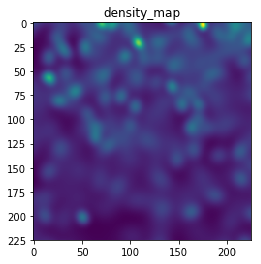

In [17]:
#visualize one random density
print '训练集图像总数:',len(Y_train)
i = int(random.random()*len(Y_train))
print '随机选取的下标为:',i

plt.imshow(np.fliplr(X_train[i]))
plt.title('src')
plt.figure()
plt.imshow(np.fliplr(Y_train[i]))
plt.title('density_map')
print '真实人数:',int(round(np.sum(Y_train[i])))

In [ ]:
# TODO: download http://www.robots.ox.ac.uk/~vgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel
# caffe train
#!caffe train -solver models/dcc_crowdnet/solver.prototxt -weights weights/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel
#!caffe train --solver models/dcc_crowdnet/solver.prototxt 
#!caffe train --solver models/dcc_crowdnet/solver.prototxt --snapshot models/dcc_crowdnet/dcc_crowdnet_train_iter_228000.solverstate

!caffe train --solver weights/solver.prototxt --snapshot  weights/dcc_crowdnet_train_iter_634000.solverstate 

print "over train"

## Test deploy

In [18]:
def image_process(img, mean):
    img = img.copy()
    img = img.transpose(2, 0, 1).astype(np.float32)
    img -= mean
    return img
    
def batch_image_process(images, mean):
    batch = np.zeros((len(images),)+images[0].transpose(2, 0, 1).shape, dtype=np.float32)
    for i, img in enumerate(images):
        batch[i] = image_process(img, mean)
    return batch

In [19]:
def predict(X_fs_deploy, mean):
    Y_fs_deploy = []
    for i, img in enumerate(X_fs_deploy):
        adapted_img, _ = adapt_images_and_densities([img], None, slice_w=patch_w, slice_h=patch_h)
        X_deploy, _ = generate_slices(adapted_img, None, slice_w=patch_w, slice_h=patch_h, offset=None)
        # net forward
        out_layer = 'conv6'
        batch_size = 10
        Y_deploy = []
        i1 = 0
        while i1 < len(X_deploy):
            if i1+batch_size < len(X_deploy):
                i2 = i1+batch_size
            else:
                i2 = len(X_deploy)
            batch = batch_image_process(X_deploy[i1:i2], mean)
            
            net.blobs['data'].reshape(batch.shape[0], batch.shape[1], batch.shape[2], batch.shape[3])
            net.blobs['data'].data[...] = batch
            net.forward() # end=penultimate_layer
            for out in net.blobs[out_layer].data:
                y = out[0] #single channel
                Y_deploy.append(y)
            i1 += batch_size
        Y_fs_deploy.append(Y_deploy)
    return Y_fs_deploy

In [20]:
def predict_oneimg(img, mean):
    adapted_img, _ = adapt_images_and_densities([img], None, slice_w=patch_w, slice_h=patch_h)
    X_deploy, _ = generate_slices(adapted_img, None, slice_w=patch_w, slice_h=patch_h, offset=None)
    # net forward
    out_layer = 'conv6'
    batch_size = 10
    Y_deploy = []
    i1 = 0
    while i1 < len(X_deploy):
        if i1+batch_size < len(X_deploy):
            i2 = i1+batch_size
        else:
            i2 = len(X_deploy)
        batch = batch_image_process(X_deploy[i1:i2], mean)
            
        net.blobs['data'].reshape(batch.shape[0], batch.shape[1], batch.shape[2], batch.shape[3])
        net.blobs['data'].data[...] = batch
        net.forward() # end=penultimate_layer
        for out in net.blobs[out_layer].data:
            y = out[0] #single channel
            Y_deploy.append(y)
        i1 += batch_size
    return Y_deploy

In [ ]:
## pridict all test image
model_def = os.path.join(model_path, 'deploy.prototxt')
for model_weights in glob.glob(os.path.join('weights', 'dcc_crowdnet_train_iter_566000.caffemodel')):
    net = caffe.Net(model_def, model_weights, caffe.TEST)
    if HAS_GPU:
        caffe.set_device(GPU_ID)
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()
    t1 = time.time()
    Y_fs_deploy = predict(X_fs_test, VGG_ILSVRC_16_layers_mean)
    print 'time:', time.time()-t1
    Y_fs_test_count = np.array(map(np.sum, Y_fs_test))
    Y_fs_deploy_count = np.array(map(np.sum, Y_fs_deploy))

    print model_weights, 'MAE:', np.average(np.absolute(Y_fs_deploy_count - Y_fs_test_count))

In [ ]:
##pridict one image
model_def = os.path.join(model_path, 'deploy.prototxt')
testsrc=X_train
realdmap=Y_train
print '测试图总数量',len(testsrc)
i = int(random.random()*len(testsrc))#Randomly select one image

for model_weights in glob.glob(os.path.join('weights', '*746000.caffemodel')): # '*634000.caffemodel'  746
    net = caffe.Net(model_def, model_weights, caffe.TEST)
    if HAS_GPU:
        caffe.set_device(GPU_ID)
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()
    t1 = time.time()
    
    Y_fs_deploy = predict_oneimg(testsrc[i], VGG_ILSVRC_16_layers_mean)
    print '选取的weights（caffemodel）',model_weights,'用时 :', time.time()-t1
    #show result
    
    print '随机选取的下标:',i
    plt.imshow(np.fliplr(testsrc[i]))
    plt.title('src')
    plt.figure()
    plt.imshow(np.fliplr(Y_fs_deploy[0]))
    #plt.imshow(np.fliplr(Y_fs[i]))
    plt.title('pridicted_density_map')
    print '真实人数:',int(round(np.sum(realdmap[i])))
    print '模型预测人数:',int(round(np.sum(Y_fs_deploy)))
   

测试图总数量 28825


weights/dcc_crowdnet_train_iter_746000.caffemodel
weights/dcc_crowdnet_train_iter_746000.caffemodel  timeused: 0.583191156387
模型预测人数: 683


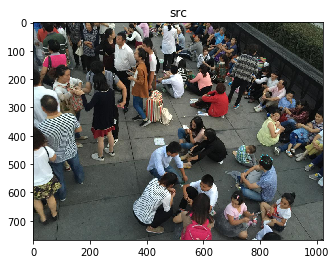

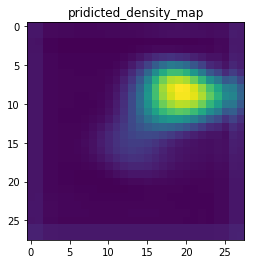

In [128]:
##pridict one image of myown

model_def = os.path.join(model_path, 'deploy.prototxt')
#imgpath='~/caffe/CrowdCount/deep-crowd-counting_crowdnet-master/dataset/UCF_CC_50/32.jpg'
#testimg =  cv2.imread(imgpath)


imgpath='~/caffe/CrowdCount/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data/images/'
testimg = mpimg.imread(imgpath+'IMG_2.jpg')


for model_weights in glob.glob(os.path.join('weights', '*746000.caffemodel')):
    print model_weights
    net = caffe.Net(model_def, model_weights, caffe.TEST)
    if HAS_GPU:
        caffe.set_device(GPU_ID)
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()
    t1 = time.time()
    
    Y_fs_deploy = predict_oneimg(testimg, VGG_ILSVRC_16_layers_mean)
    print model_weights,' timeused:', time.time()-t1
    #show result
    plt.imshow(np.fliplr(testimg))
    plt.title('src')
    plt.figure()
    plt.imshow(np.fliplr(Y_fs_deploy[0]))
    #plt.imshow(np.fliplr(Y_fs[i]))
    plt.title('pridicted_density_map')
    print '模型预测人数:',int(round(np.sum(Y_fs_deploy)))
   